## Step 1:
Let the program know where to find your tools file.

In [1]:
import sys, os
sys.path.append(os.path.join(os.path.realpath(".."), "Tools"))

## Step 2:
Load up all of the necessary packages

In [2]:
from plastid import BAMGenomeArray,GTF2_TranscriptAssembler,Transcript
import numpy as np
import pandas as pd
from plastid.plotting.plots import *
import utilities as utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from Bio import SeqIO
from Bio.Alphabet import generic_dna
from Bio.Seq import Seq
from scipy import stats
import math

%matplotlib inline

## Step 3:
define the paths to our reference genome and annotation files as well as the path to our list of autism spectrum disorder (ASD) genes

In [223]:
reference_path = "/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/genome/dmel/"
data_path = "/home/keeganfl/Desktop/measuring_binding_domains/data/"
figure_path = "/home/keeganfl/Desktop/measuring_binding_domains/Q20/reworked_figures/"
table_path = "/home/keeganfl/Desktop/measuring_binding_domains/Q20/Tables/"

## Step 4: 
load the transcript and genome files so that we can find the sequence of each gene

In [4]:
# Loading up the transcrip[t information.
transcripts = list(GTF2_TranscriptAssembler(open(reference_path + "mm10.refGene.gtf"),return_type=Transcript))

# Loading up the genome information. 
genome = SeqIO.to_dict(SeqIO.parse(open(reference_path + "mm10.fa"),"fasta"))

## Step 5:
Create a dataframe that contains the gene name, gene length, and the counts for the FMRP target mRNA sequences

In [133]:
# Choose the motif to analyze
motif = ["GAC"]
# Create a dataframe with all of the count data I want. 
GAC_counts = utils.counter(transcripts, genome, sites = motif)

---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/measuring_binding_domains/Tools/utilities.py, line 66:

64     # get the count density for each region.
65     density_cds = np.array(total_cds)/np.array(lengths_cds)
66     density_utr5 = np.array(total_utr5)/np.array(lengths_utr5)
67     density_utr3 = np.array(total_utr3)/np.array(lengths_utr3)
68     density_all = np.array(total_all)/np.array(lengths_all)

---------------------------------------------------------------------------
---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/measuring_binding_domains/Tools/utilities.py, line 67:

65     density_cds = np.array(total_cds)/np.array(lengths_cds)
66     density_utr5 = np.array(total_utr5)/np.array(lengths_utr5)
67     density_utr3 = np.array(total_utr3)/np.array(lengths_

In [134]:
# Choose the motif to analyze
motif = ["AGGA", "UGGA"]
# Create a dataframe with all of the count data I want. 
WGGA_counts = utils.counter(transcripts, genome, sites = motif)

In [135]:
# Choose the motif to analyze
motif = ["ACUU", "ACUG"]
# Create a dataframe with all of the count data I want. 
ACUK_counts = utils.counter(transcripts, genome, sites = motif)

In [136]:
# Choose the motif to analyze
motif = ["UUUU"]
# Create a dataframe with all of the count data I want. 
TTTT_counts = utils.counter(transcripts, genome, sites = motif)

In [137]:
# Choose the motif to analyze
motif = ["UAU", "UAC"]
# Create a dataframe with all of the count data I want. 
TAY_counts = utils.counter(transcripts, genome, sites = motif)

In [191]:
# Choose the motif to analyze
motif = ["CCAU", "CCAG"]
# Create a dataframe with all of the count data I want. 
random_counts = utils.counter(transcripts, genome, sites = motif)

---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/measuring_binding_domains/Tools/utilities.py, line 66:

64     # get the count density for each region.
65     density_cds = np.array(total_cds)/np.array(lengths_cds)
66     density_utr5 = np.array(total_utr5)/np.array(lengths_utr5)
67     density_utr3 = np.array(total_utr3)/np.array(lengths_utr3)
68     density_all = np.array(total_all)/np.array(lengths_all)

---------------------------------------------------------------------------
---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/measuring_binding_domains/Tools/utilities.py, line 67:

65     density_cds = np.array(total_cds)/np.array(lengths_cds)
66     density_utr5 = np.array(total_utr5)/np.array(lengths_utr5)
67     density_utr3 = np.array(total_utr3)/np.array(lengths_

In [192]:
count_list = [GAC_counts, WGGA_counts, ACUK_counts, TTTT_counts, TAY_counts, random_counts]
motif_list = ["GAC", "WGGA", "ACUK", "TTTT", "TAY"]

## Step 6:
Load up the list of APRIS genes. This list will include the transcript IDs of all of the primary isoforms, and will be used to select a single transcript for all genes.

In [193]:
# Load up the Apris genes. 
prin_trans = pd.read_csv(data_path + "apris_mouse_data.txt", names = ["gene_name", "???", "gene_id", "rank"])

# Remove the extra decimal point from the gene ids so that the gene IDs are the same. 
gene_ids = [] 
for i in prin_trans.gene_id:
    gene_ids.append(i.split('.',1)[0])
prin_trans.gene_id = gene_ids

In [194]:
new_count_list = []
for i in count_list:
    # Merge the count table with the table of ASD gene names and include an indicator column.
    mouse_counts = pd.merge(i, prin_trans, how="left", on="gene_id", indicator = True)

    # Only keep counts with a transcript ID that matched one of the APRIS primary IDs.
    mouse_counts = mouse_counts.loc[mouse_counts._merge == "both"].copy()

    # Drop any duplicate genes (duplicates may remain if multiple transcripts have identical cds regions).
    mouse_counts.drop_duplicates(subset ="gene_name_x",keep = "first", inplace = True) 

    # Remove unnecesary columns. 
    mouse_counts.drop(columns = ["gene_name_y", "???", "rank", "_merge"], inplace = True)
    new_count_list.append(mouse_counts)

## Step 7:
Load up a list the top 200 most significantly changed genes and then select the 100 most significantly downregulated genes. 

In [236]:
top_400 = pd.read_csv(data_path + "mmus_top_400.csv")
top_downreg = top_400.query('Fold_change < 1')[0:100]
top_upreg = top_400.query('Fold_change > 1')[0:100]

## Step 8:
merge the asd_gene_names and the fly counts together based on the shared gene names

In [238]:
merged_down = []
merged_up = []
for i in new_count_list:
    temp_df = pd.merge(i, top_downreg, how="left", left_on = "gene_name_x", right_on = "gene_ID", indicator = True)
    temp_df = temp_df.reset_index(drop=True)
    # remove extremely long genes as they effect the analysis
    temp_df = temp_df.drop(temp_df[temp_df.lengths_all > 35000].index)
    merged_down.append(temp_df)
    
    temp_df = pd.merge(i, top_upreg, how="left", left_on = "gene_name_x", right_on = "gene_ID", indicator = True)
    temp_df = temp_df.reset_index(drop=True)
    # remove extremely long genes as they effect the analysis
    temp_df = temp_df.drop(temp_df[temp_df.lengths_all > 35000].index)
    merged_up.append(temp_df)

## Step 9:
split the merged table into downreg_genes and non_downreg_genes tables

In [239]:
downreg_list = []
non_downreg_list = []
upreg_list = []
non_upreg_list = []

for up,down in zip(merged_up, merged_down):
    # split it into downreg_genes and non_downreg_genes tables
    downreg_genes = down.loc[down._merge == "both"].copy()

    non_downreg_genes = down.loc[down._merge == "left_only"].copy()

    # drop the unecessary columns
    non_downreg_genes.drop(columns = ["_merge"], inplace = True)

    # Reset the indices
    downreg_genes = downreg_genes.reset_index(drop=True)
    non_downreg_genes = non_downreg_genes.reset_index(drop=True)
    downreg_list.append(downreg_genes)
    non_downreg_list.append(non_downreg_genes)
    
    # split it into upreg_genes and non_upreg_genes tables
    upreg_genes = up.loc[up._merge == "both"].copy()

    non_upreg_genes = up.loc[up._merge == "left_only"].copy()

    # drop the unecessary columns
    non_upreg_genes.drop(columns = ["_merge"], inplace = True)

    # Reset the indices
    upreg_genes = upreg_genes.reset_index(drop=True)
    non_upreg_genes = non_upreg_genes.reset_index(drop=True)
    upreg_list.append(upreg_genes)
    non_upreg_list.append(non_upreg_genes)

## Step 10
Create a set of violin plots that show the distribution of FMRP binding site density in autism genes and non-autism genes. 

In [251]:
# Use the permutation test to determine if the FMRP binding site density is significantly
# different for ASD genes.

p_up_list = []
p_down_list = []
for down, non_down, up, non_up in zip(downreg_list, non_downreg_list,
                                      upreg_list, non_upreg_list):

    up_test = stats.ttest_ind(up.density_all, non_up.density_all, equal_var = True,
                nan_policy = "omit", alternative = "greater")

    down_test = stats.ttest_ind(down.density_all, non_down.density_all, equal_var = True,
                nan_policy = "omit", alternative = "greater")
    
    p_up_list.append(round(up_test[1], 6))
    p_down_list.append(round(down_test[1], 6))

In [252]:
p_down_list

[0.003249, 0.000447, 1.0, 0.999996, 1.0, 0.0]

In [249]:
downreg_density_list = [downreg_list[0].density_all,
                     downreg_list[1].density_all, 
                     downreg_list[2].density_all, 
                     downreg_list[3].density_all,
                     downreg_list[4].density_all]
other_density_list = [non_downreg_list[0].density_all,
                     non_downreg_list[1].density_all, 
                     non_downreg_list[2].density_all, 
                     non_downreg_list[3].density_all,
                     non_downreg_list[4].density_all]

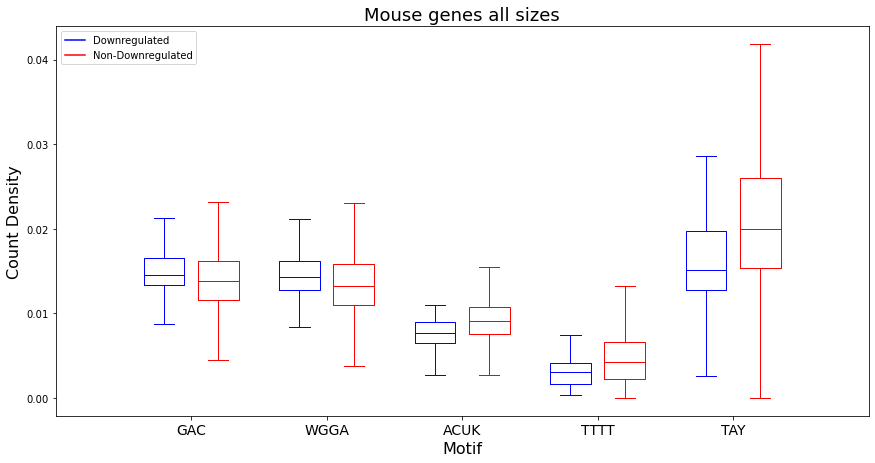

In [256]:
ticks = ["GAC", "WGGA", "ACUK", "TTTT", "TAY"]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize = (12,6))

bpl = plt.boxplot(downreg_density_list, positions=np.array(range(len(downreg_density_list)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(other_density_list, positions=np.array(range(len(other_density_list)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, "blue") # colors are from http://colorbrewer2.org/
set_box_color(bpr, 'red')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c="blue", label='Downregulated')
plt.plot([], c='red', label='Non-Downregulated')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, fontsize = 14)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.savefig('boxcompare.png')
plt.ylabel("Count Density", fontsize = 16)
plt.xlabel("Motif", fontsize = 16)
plt.title("Mouse genes all sizes", fontsize = 18)

plt.savefig(figure_path + "mouse_down_freq.pdf")

In [254]:
upreg_density_list = [upreg_list[0].density_all,
                     upreg_list[1].density_all, 
                     upreg_list[2].density_all, 
                     upreg_list[3].density_all,
                     upreg_list[4].density_all]
non_upreg_density_list = [non_upreg_list[0].density_all,
                     non_upreg_list[1].density_all, 
                     non_upreg_list[2].density_all, 
                     non_upreg_list[3].density_all,
                     non_upreg_list[4].density_all]

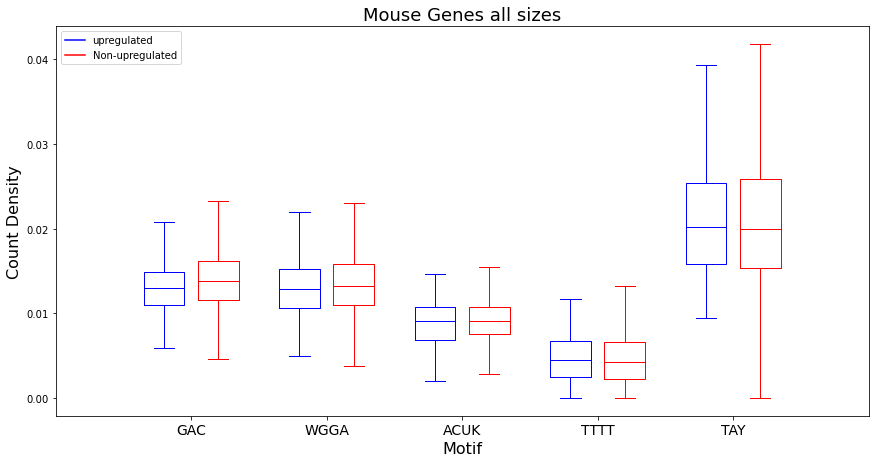

In [257]:
ticks = ["GAC", "WGGA", "ACUK", "TTTT", "TAY"]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize = (12,6))

bpl = plt.boxplot(upreg_density_list, positions=np.array(range(len(upreg_density_list)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(non_upreg_density_list, positions=np.array(range(len(non_upreg_density_list)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, 'blue') # colors are from http://colorbrewer2.org/
set_box_color(bpr, 'red')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='blue', label='upregulated')
plt.plot([], c='red', label='Non-upregulated')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, fontsize = 14)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.ylabel("Count Density", fontsize = 16)
plt.xlabel("Motif", fontsize = 16)
plt.title("Mouse Genes all sizes", fontsize = 18)

plt.savefig(figure_path + "mouse_up_freq.pdf")

In [261]:
motif_list

['GAC', 'WGGA', 'ACUK', 'TTTT', 'TAY']

In [264]:
for up, non_up, down, non_down, motif in zip(upreg_list, non_upreg_list,
                                      downreg_list, non_downreg_list, motif_list):
    means = [(up.density_all).mean(axis=0),(non_up.density_all).mean(axis=0),
                (down.density_all).mean(axis=0),
                (non_down.density_all).mean(axis=0)]
    samples = ["Upregulated", "Non-upregulated Short", "Downregulated", "Non-downregulated"]

    # Get the fraction of non-downregulated genes above the mean count of the downregulated genes. 
    up_frac = len(non_up.query("density_all > " + str(means[0])).density_all)/len(non_up.density_all)
    down_frac = len(non_down.query("density_all > " + str(means[2])).density_all)/len(non_down.density_all)
    
    up_test = stats.ttest_ind(up.density_all, non_up.density_all, equal_var = True,
                nan_policy = "omit", alternative = "greater")

    down_test = stats.ttest_ind(down.density_all, non_down.density_all, equal_var = True,
                nan_policy = "omit", alternative = "greater")
    
    p_values = [np.nan, round(up_test[1],6), np.nan, round(down_test[1],6)]

    frac = [np.nan, up_frac, np.nan, down_frac]

    df = pd.DataFrame(zip(samples,means,frac, p_values), columns = ["Sample", "Mean " + motif + " Frequency", "Fraction of Non-downregulated above mean", "P values"])
    df.to_csv(table_path + motif + "_mouse_data", index = False)

## Step 11
Create a set of violin plots that show the distribution of total FMRP binding sites and CDS length for autism and non-autism genes

In [221]:
# Use the permutation test to determine if the FMRP binding site density is significantly
# different for ASD genes.
total_count_p_list = []
for downreg, non_downreg in zip(downreg_list, non_downreg_list):

    test = stats.ttest_ind(downreg.total_all, non_downreg.total_all, equal_var = True,
                nan_policy = "omit")

    total_count_p_list.append(test[1])

In [222]:
total_count_p_list

[4.243014499048481e-132,
 3.859080455569281e-120,
 1.8718804599521485e-56,
 2.1504607550822133e-10,
 1.0746100030803156e-37,
 1.267195589428343e-168]

In [206]:
downreg_total_list = [downreg_list[1].total_all, 
                     downreg_list[2].total_all, 
                     downreg_list[5].total_all]
other_total_list = [non_downreg_list[1].total_all, 
                     non_downreg_list[2].total_all, 
                     non_downreg_list[5].total_all]

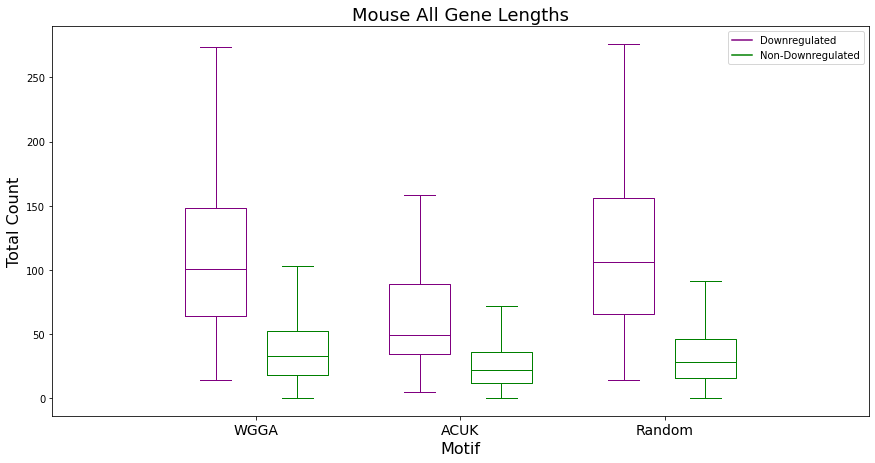

In [226]:
ticks = ["WGGA", "ACUK", "Random"]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize = (12,6))

bpl = plt.boxplot(downreg_total_list, positions=np.array(range(len(downreg_total_list)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(other_total_list, positions=np.array(range(len(other_total_list)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, "purple") # colors are from http://colorbrewer2.org/
set_box_color(bpr, 'green')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c="purple", label='Downregulated')
plt.plot([], c='green', label='Non-Downregulated')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, fontsize = 14)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.savefig('boxcompare.png')
plt.ylabel("Total Count", fontsize = 16)
plt.xlabel("Motif", fontsize = 16)
plt.title("Mouse All Gene Lengths", fontsize = 18)

plt.savefig(figure_path + "mouse_all_counts.pdf")

# Conclusions:
from the data I am currently able to observe, I can conclude that although the total number of binding sites is higher in ASD gene populations, this is basically entirely dependent on the fact that the ASD genes are generally longer. When looking at binding site frequency/density, there is essentially no change whatsoever. 